In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, precision_score, recall_score, roc_auc_score

from itertools import islice
from functools import partial
import mxnet as mx
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from gluonts.dataset.loader import TrainDataLoader
from gluonts.mx import DeepAREstimator
from gluonts.mx.util import get_hybrid_forward_input_names
from gluonts.mx.trainer import Trainer
from gluonts.mx.batchify import batchify
from gluonts.dataset.repository.datasets import get_dataset

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
df=pd.read_csv("data/walmart_cleaned.csv")
df_temp = df.copy()
df_temp['Date'].min(), df_temp['Date'].max(), df_temp[df_temp['Date']=='2010-02-05'].shape,

('2010-02-05', '2012-10-26', (2955, 17))

In [3]:
df_temp[(df_temp['Store']==1)]['Dept'].nunique()

77

In [4]:
df_temp = df_temp[(df_temp['Dept']==1) & (df_temp['Store']==1)]
df_temp['Date'].min(), df_temp['Date'].max(), df_temp.shape

('2010-02-05', '2012-10-26', (143, 17))

In [5]:
df_temp.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
137,137,1,2010-02-12,1,1.0,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,3,151315
192,192,1,2010-02-19,0,1.0,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,3,151315
273,273,1,2010-02-26,0,1.0,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,3,151315
313,313,1,2010-03-05,0,1.0,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,3,151315


In [6]:
df_temp['Date'] = pd.to_datetime(df_temp['Date'])
df_temp = df_temp.set_index('Date')
df_req = df_temp[["Weekly_Sales"]]
# take a look
df_req.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [7]:
freq = "7D"             # the frequency of our data, here daily
context_length    = 70 # train on this number of days
prediction_length =  14 # predict these many days, these are removed from the end of the training data

In [8]:
from gluonts.dataset.common import ListDataset

data_list = [{"start": "2010-02-05", "target": df_req[c].values} for c in df_req.columns]
train_ds  = ListDataset(data_iter=data_list,freq=freq)

In [9]:
train_ds

[{'start': Period('2010-02-05', '7D'),
  'target': array([24924.5 , 46039.49, 41595.55, 19403.54, 21827.9 , 21043.39,
         22136.64, 26229.21, 57258.43, 42960.91, 17596.96, 16145.35,
         16555.11, 17413.94, 18926.74, 14773.04, 15580.43, 17558.09,
         16637.62, 16216.27, 16328.72, 16333.14, 17688.76, 17150.84,
         15360.45, 15381.82, 17508.41, 15536.4 , 15740.13, 15793.87,
         16241.78, 18194.74, 19354.23, 18122.52, 20094.19, 23388.03,
         26978.34, 25543.04, 38640.93, 34238.88, 19549.39, 19552.84,
         18820.29, 22517.56, 31497.65, 44912.86, 55931.23, 19124.58,
         15984.24, 17359.7 , 17341.47, 18461.18, 21665.76, 37887.17,
         46845.87, 19363.83, 20327.61, 21280.4 , 20334.23, 20881.1 ,
         20398.09, 23873.79, 28762.37, 50510.31, 41512.39, 20138.19,
         17235.15, 15136.78, 15741.6 , 16434.15, 15883.52, 14978.09,
         15682.81, 15363.5 , 16148.87, 15654.85, 15766.6 , 15922.41,
         15295.55, 14539.79, 14689.24, 14537.37, 15277

In [11]:
from gluonts.mx import DeepAREstimator
estimator = DeepAREstimator(
        prediction_length=prediction_length,
        context_length = context_length,
        freq=freq,
        trainer=Trainer(
            learning_rate=1e-3, epochs=2, num_batches_per_epoch=100
        ),
    )

In [12]:
%%time
# instead of calling `train` method, we call `train_model` that returns more things including the training model
train_output = estimator.train_model(train_ds)
print("Done")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.44it/s, epoch=2/2, avg_epoch_loss=9.76]

Done
CPU times: user 18.2 s, sys: 273 ms, total: 18.5 s
Wall time: 18.1 s


In [13]:
input_names = get_hybrid_forward_input_names(
        type(train_output.trained_net)
    )

# we construct a data_entry that contains 500 random windows
batch_size = 100
num_samples = 50
instance_splitter = estimator._create_instance_splitter("training")

In [14]:
training_data_loader = TrainDataLoader(
        dataset=train_ds,
        transform=train_output.transformation + instance_splitter,
        batch_size=batch_size,
        num_batches_per_epoch=estimator.trainer.num_batches_per_epoch,
        stack_fn=partial(
            batchify, ctx=estimator.trainer.ctx, dtype=estimator.dtype
        ),
    )

data_entry = next(iter(training_data_loader))

In [15]:
# we now call the train model to get the predicted distribution on each window
# this allows us to investigate where are the biggest anomalies
context_length = train_output.trained_net.context_length
prediction_length = train_output.trained_net.prediction_length

distr = train_output.trained_net.distribution(
    *[data_entry[k] for k in input_names]
)

In [16]:
# gets all information into numpy array for further plotting
samples = distr.sample(num_samples).asnumpy()
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])
target = mx.ndarray.concat(
    data_entry["past_target"], data_entry["future_target"], dim=1
)
target = target[:, -(context_length + prediction_length) :]
nll = -distr.log_prob(target).asnumpy()
target = target.asnumpy()
mean = samples.mean(axis=0)
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])

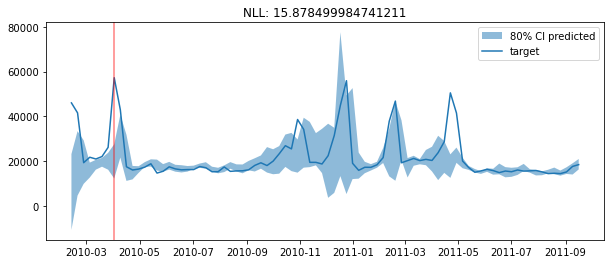

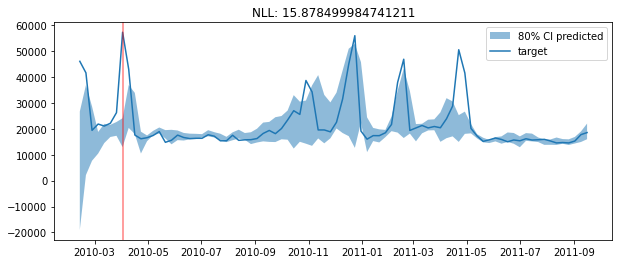

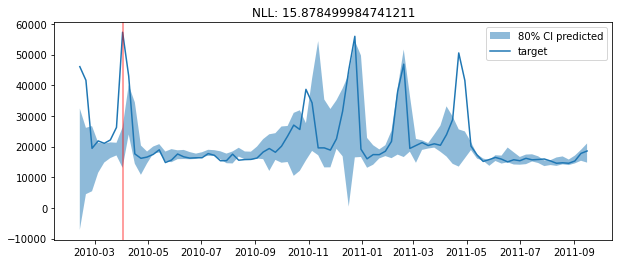

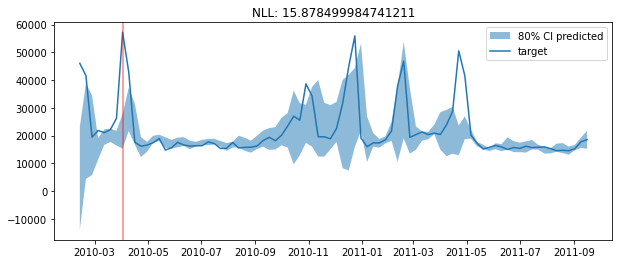

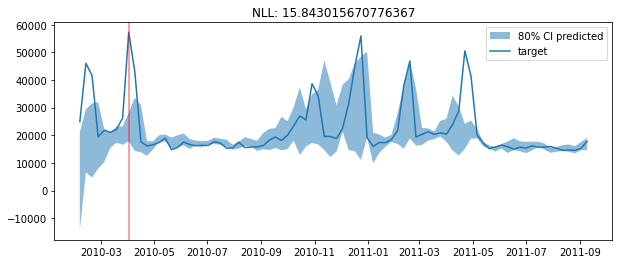

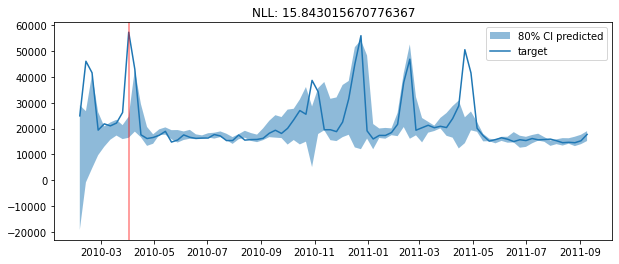

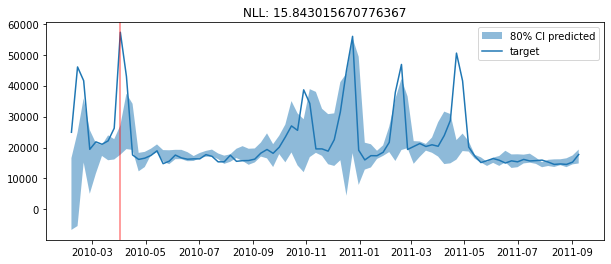

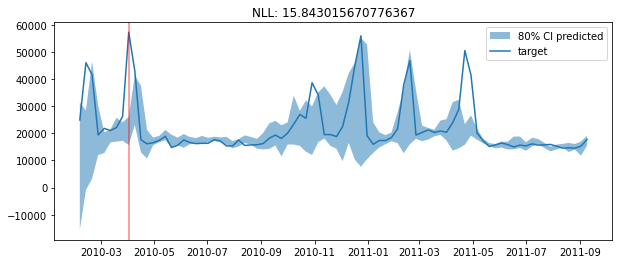

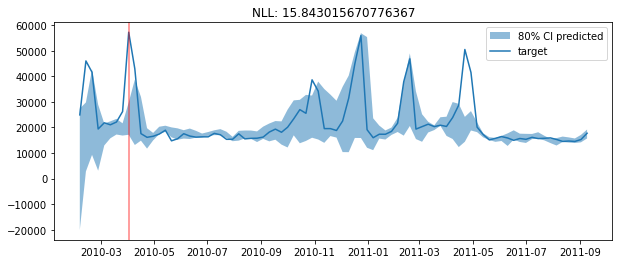

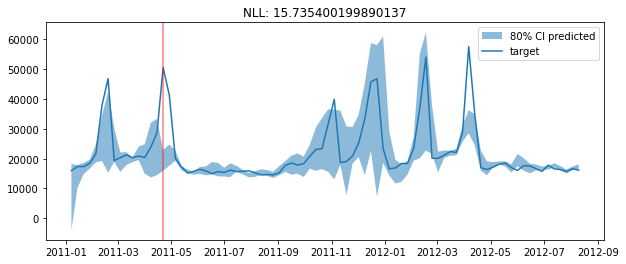

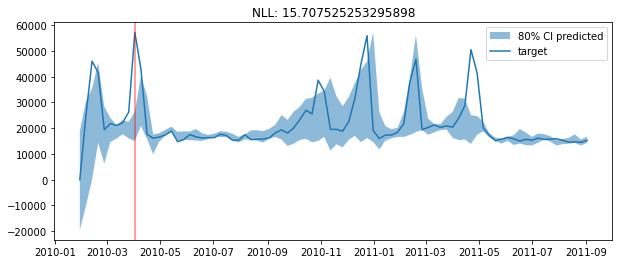

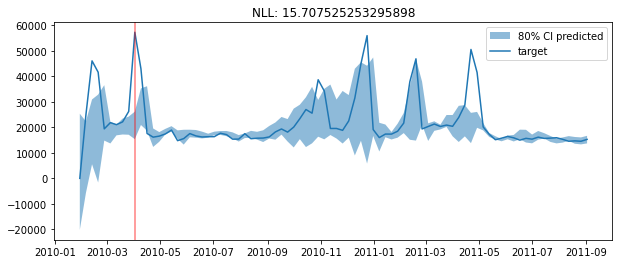

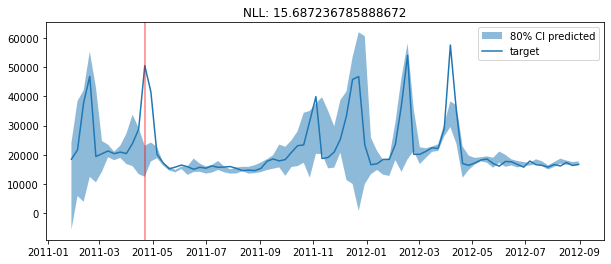

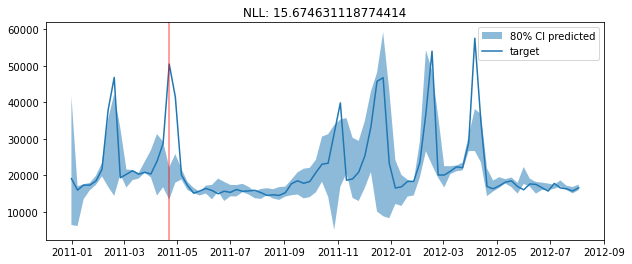

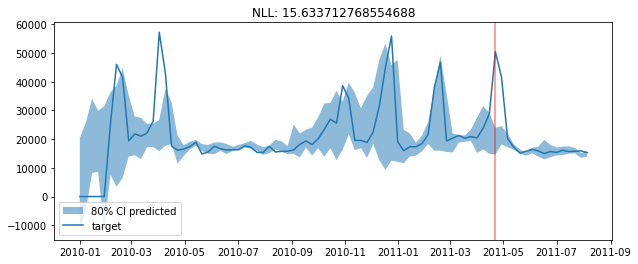

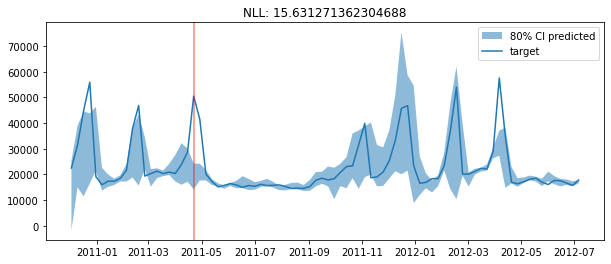

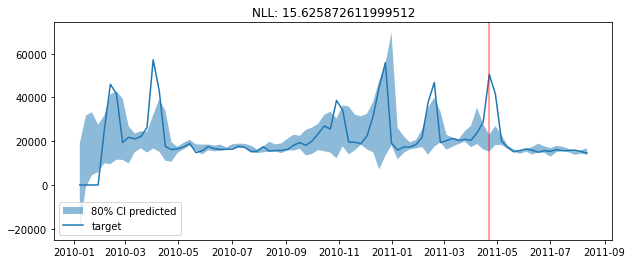

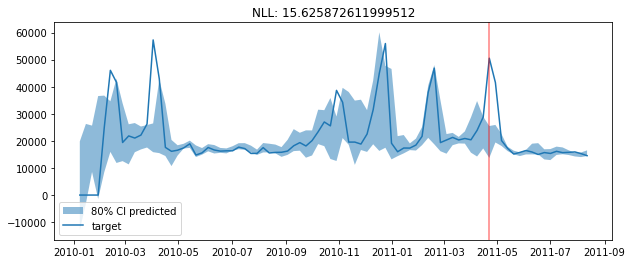

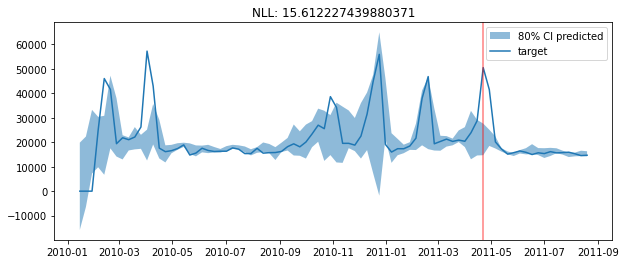

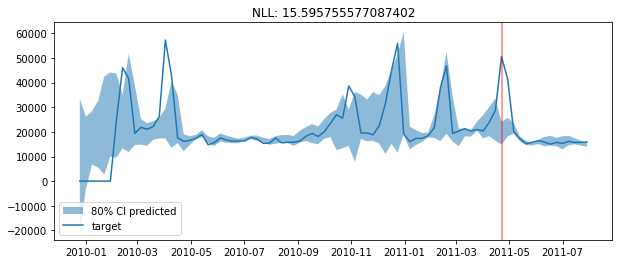

In [17]:
# NLL indices from largest to smallest
sorted_indices = np.argsort(nll.reshape(-1))[::-1]

# shows the series and times when the 20 largest NLL were observed
for k in sorted_indices[:20]:
    i = k // nll.shape[1]
    t = k % nll.shape[1]

    time_index = pd.period_range(
        data_entry["forecast_start"][i],
        periods=context_length + prediction_length,
        freq=data_entry["forecast_start"][i].freq,
    )
    time_index -= context_length * time_index.freq

    plt.figure(figsize=(10, 4))
    plt.fill_between(
        time_index.to_timestamp(),
        percentiles[0, i],
        percentiles[-1, i],
        alpha=0.5,
        label="80% CI predicted",
    )
    plt.plot(time_index.to_timestamp(), target[i], label="target")
    plt.axvline(time_index[t].to_timestamp(), alpha=0.5, color="r")
    plt.title(f"NLL: {nll[i, t]}")
    plt.legend()
    plt.show()